## Spatially resolved Mass-Metallicity relation for EDGE, at CALIFA resolution.

In [1]:
import os
import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astropy import units as u
import h5py 
import sys
sys.path.append('~/Library/Python/3.6/lib/python/site-packages/')
sys.path.append('../edge_pydb')
from edge_conv import stmass_pc2, msd_co, ZOH_o3n2, xy2hist

## Inspect the CALIFA HDF5 file

In [2]:
if os.path.exists('../img_califa/edge.pipe3d.hdf5'):
    print('Working on full EDGE database')
    califatab = '../img_califa/edge.pipe3d.hdf5'
else:
    print('Working on NGC 4047 data')
    califatab = '../img_califa/NGC4047.pipe3d.hdf5'
f = h5py.File(califatab, 'r')
list(f.keys())

Working on full EDGE database


['ELINES_rg',
 'ELINES_rg.__table_column_meta__',
 'ELINES_sm',
 'ELINES_sm.__table_column_meta__',
 'SFH_rg',
 'SFH_rg.__table_column_meta__',
 'SFH_sm',
 'SFH_sm.__table_column_meta__',
 'SSP_rg',
 'SSP_rg.__table_column_meta__',
 'SSP_sm',
 'SSP_sm.__table_column_meta__',
 'flux_elines_rg',
 'flux_elines_rg.__table_column_meta__',
 'flux_elines_sm',
 'flux_elines_sm.__table_column_meta__',
 'indices_rg',
 'indices_rg.__table_column_meta__',
 'indices_sm',
 'indices_sm.__table_column_meta__']

## Build the table

In [3]:
felines = Table.read(califatab, path='flux_elines_rg')
ssp_rg  = Table.read(califatab, path='SSP_rg')
join2   = join(felines, ssp_rg)
# For stellar surface density we need distance
globaldir = '../dat_glob/'
califa  = Table.read(globaldir+'external/edge_califa.csv', format='ascii.ecsv')
dists   = Table([califa['Name'], califa['caDistMpc']])
join3   = join(join2, dists, keys='Name')
print(join3.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel_[SII]6731', 'e_disp_[OII]372

## Calculate the metallicity

In [4]:
ZOH = ZOH_o3n2(join3, err=False)
print('Number of points:',len(ZOH))

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
../edge_pydb/edge_conv.py:92: RuntimeWarning: invalid value encountered in log10
  n2ha = np.log10(flux_nii)  - np.log10(flux_ha)
../edge_pydb/edge_conv.py:93: RuntimeWarning: invalid value encountered in log10
  o3hb = np.log10(flux_oiii) - np.log10(flux_hb)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Number of points: 351125


## Plot the mass-metallicity relation

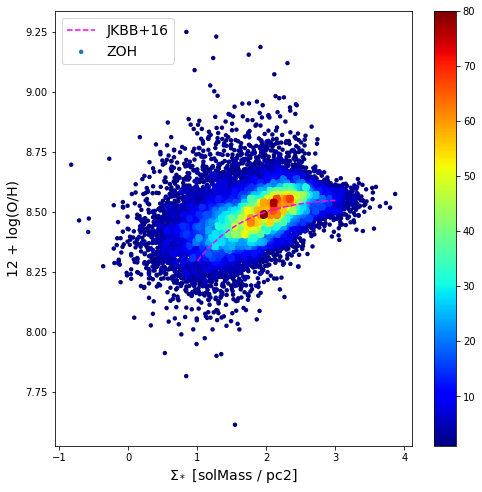

In [5]:
sig_star = stmass_pc2(join3['mass_ssp'], dist=join3['caDistMpc'].quantity)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(ZOH)) & (sig_star>0) & (ZOH>0)
x_det, y_det, z_det, *hist = xy2hist(np.log10(sig_star[not_nan]), 
                                     ZOH[not_nan], log=False)

fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
# From MaNGA paper, doi:10.1093/mnras/stw1984
xmod = np.linspace(1,3,num=50)
ymod = 8.55 + 0.014*(xmod-3.14)*np.exp(-(xmod-3.14))
plt.plot(xmod,ymod,color='magenta',ls='--',label='JKBB+16')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('$\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel('12 + log(O/H)',fontsize=14)
plt.colorbar(sc)